In [4]:
import pandas as pd

from pathlib import Path
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from math import ceil

#preprocessing
from unidecode import unidecode
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
from nltk.stem import RSLPStemmer

#train/test split
from sklearn.model_selection import StratifiedKFold

#vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
#Read the data
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)

df = df.drop(['link', 'date'], axis = 1)

df.head()

,category,headline,authors,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ..."


In [6]:
print(df.isnull().sum()) #No nan values

category             0
headline             0
authors              0
short_description    0
dtype: int64


In [7]:
# get the word count for all the documents
word_count1 = df['headline'].apply(lambda x: len(str(x).split(" ")))
df['headline_count'] = word_count1

word_count2 = df['short_description'].apply(lambda x: len(str(x).split(" ")))
df['shot_description_count'] = word_count2

df.head()

,category,headline,authors,short_description,headline_count,shot_description_count
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,14,6
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,10,15
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,11,14
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",13,13


In [8]:
df[['headline_count', 'shot_description_count']].describe()

,headline_count,shot_description_count
count,200853.000000,200853.000000
mean,9.541237,19.844443
std,3.094313,14.315444
min,1.000000,1.000000
25%,7.000000,10.000000
50%,10.000000,19.000000
75%,12.000000,24.000000
max,65.000000,243.000000


In [9]:
df.groupby(['category']).sum() #it seems that the dataset is balanced

,headline_count,shot_description_count
category,,
ARTS,13416,33039
ARTS & CULTURE,14182,16998
BLACK VOICES,47067,77640
BUSINESS,54226,132504
COLLEGE,10617,25686
COMEDY,51699,65384
CRIME,34303,46965
CULTURE & ARTS,9702,26271
DIVORCE,30903,88353


In [44]:
def countWords(serie):
    
    """Get the frequency of the words all over the dataset"""

    all_words_description = ' '.join(serie).split()

    freq = pd.Series(all_words_headline).value_counts()

    return freq

In [45]:
freq_headline = countWords(df['headline'])
freq_description = countWords(df['short_description'])

In [46]:
def countWords(serie):

    all_words_description = ' '.join(serie).split()

    freq = pd.Series(all_words_headline).value_counts()

    return freq

In [47]:
#Stop words
#nltk.download('stopwords') #uncomment this to download the english stop words
stop_words = set(stopwords.words("english"))

In [55]:
def countStopWords(freq):
    
    count = 0

    # count the frequent words which are also stop words
    for word in freq.index[:200852]: #shape
        if word in stop_words:
            count += 1
            
    return count

In [56]:
countStopWords(freq_description)

99

In [57]:
countStopWords(freq_headline)

99

In [58]:
#Get the most comum words
def get_top_n_grams(corpus, top_k, n):
    """
    Function that receives a list of documents (corpus) and extracts
        the top k most frequent n-grams for that corpus.
        
    :param corpus: list of texts
    :param top_k: int with the number of n-grams that we want to extract
    :param n: n gram type to be considered 
             (if n=1 extracts unigrams, if n=2 extracts bigrams, ...)
             
    :return: Returns a sorted Pandas DataFrame in which the first column 
        contains the extracted ngrams and the second column contains
        the respective counts
    """
    # get the top 2000 n-grams
    vec = CountVectorizer(ngram_range = (n, n), max_features = 2000).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    
    # count how many times a word appears in the corpora
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
        
    # save the frequencies in a Pandas DataFrame
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]
    return top_df

In [51]:
def plot_frequencies(top_df):
    """
    Function that receives a Pandas DataFrame from the "get_top_n_grams" function
        and plots the frequencies in a bar plot.
        
    :param top_df: a sorted Pandas DataFrame in which the first column 
        contains the top k ngrams and the second column contains
        the respective counts
    """
    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()

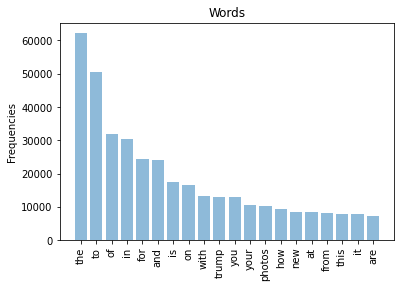

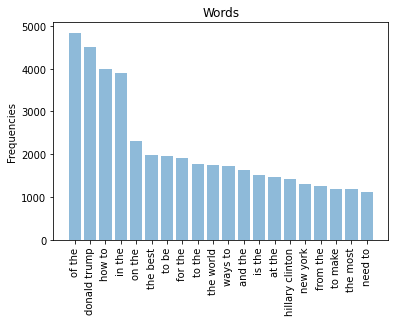

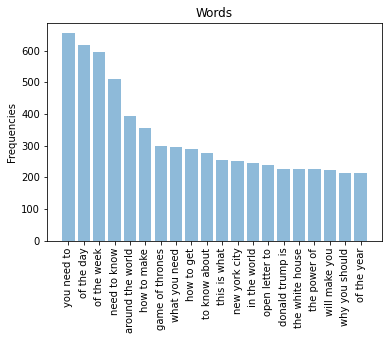

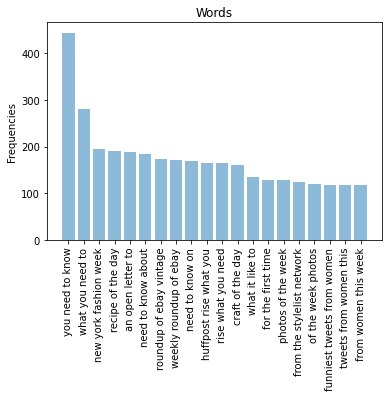

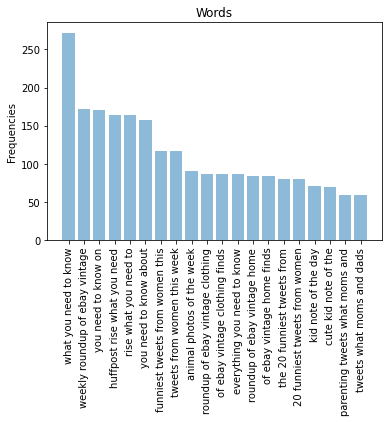

In [52]:
# plot the distribution of the top 20 n-grams with n up to 5 for headline column
for i in range(1,6):
    top = get_top_n_grams(df["headline"], top_k = 20, n = i)
    plot_frequencies(top)

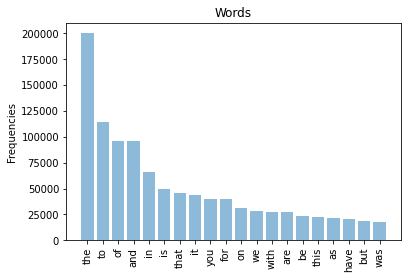

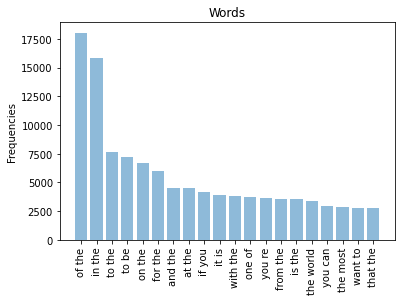

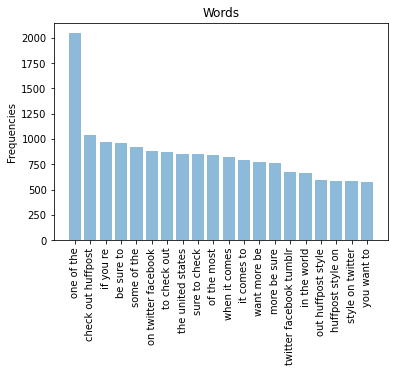

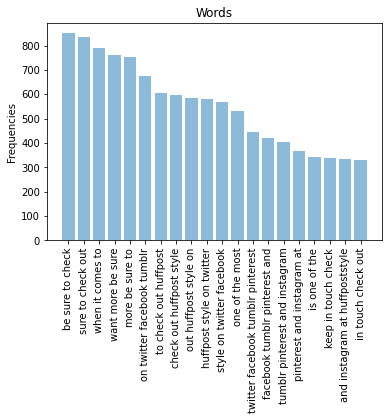

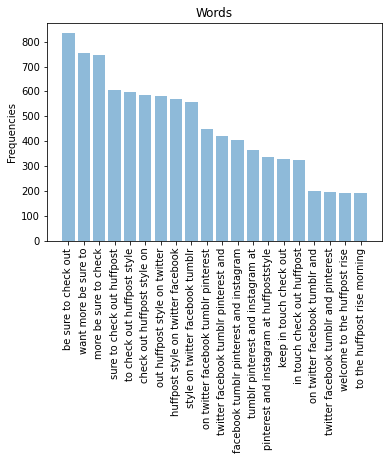

In [53]:
# plot the distribution of the top 20 n-grams with n up to 5 for short_description column
for i in range(1,6):
    top = get_top_n_grams(df["short_description"], top_k  =20, n = i)
    plot_frequencies(top)

## Preprocessing

In [54]:
def preprocessing(dataframe, punctuation = False, tags = False, stemming = False, stemmer = 'snowball'):
    """
    Function that receives a Pandas DataFrame with the texts and applies
        the chosen preprocessing techiniques.
        
    :param dataframe: a Pandas DataFrame in which the first column 
        contains the estracted texts the second column contains the
        respective authors
    :param punctuation: bool determining whether or remove punctuation
        and numbers or not (default: False)
    :param tags: bool determining whether to remove tags or not
        (default: False)
    :param stemming: bool determining whether to perform stemming or not
        (default: False)
    :param stemmer: str specifying which stemmer to use (default: 'snowball')
    
             
    :return: Returns a list of strings which correspond to each text after
        preprocessing
    """
    
    processed_corpus = []
    
    stop_words_pt = set(stopwords.words("english"))
    
    # for each text in the Pandas DataFrame
    for i in tqdm(range(len(dataframe))):
        text = dataframe['Text'][i]
                
        # remove punctuation
        if punctuation:
            text = re.sub('[^a-zA-Z]', ' ', text)

        # remove tags
        if tags:
            text = BeautifulSoup(text).get_text()
        
        # convert to list from str
        text = text.split()

        # stemming
        if stemming:
            # choose the stemmer
            if stemmer == 'snowball':
                stemmer_pt = SnowballStemmer('portuguese')
            elif stemmer == 'rslp':
                stemmer_pt = RSLPStemmer()
            
            # don't stem stop words so that they can still be detected
            text = [stemmer_pt.stem(word) for word in text if not word in stop_words_pt]
        
        # convert to str from list
        text = " ".join(text)

        # save the preprocessed text on a list
        processed_corpus.append(text)
    return processed_corpus

## Tests

In [59]:
# preprocess the text and save it in a Pandas Series
cleaned_corpora = preprocessing(
    df,
    #punctuation=True,
    #tags=True,
    stemming=True,
    stemmer='rslp'
)
df['clean_headline'] = pd.Series(cleaned_corpora, index = df.index)
df['clean_short_description'] = pd.Series(cleaned_corpora, index = df.index)

<ipython-input-54-a2ff0dac503c>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(dataframe))):


ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html